# Import

In [1]:
import copy
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error
)
from models.sarimax_2 import Model
import pickle

# Constants

In [2]:
DATA_PATH = "data/psh_microgrid.csv"
MODEL_PATH = "models/sarimax_168_24.pkl"

HISTORY_LENGTH = 7*24
FORECAST_LENGTH = 24

LATITUDE = 18.852
LONGITUDE = 98.994
TIMEZONE = TimezoneFinder().certain_timezone_at(lat=LATITUDE, lng=LONGITUDE)

TIMESTAMP_COLUMN = "timestamp"
VALUE_COLUMN = "total_power"
FEATURES = [TIMESTAMP_COLUMN, VALUE_COLUMN]

# Utils

In [3]:
def get_history(timeseries: pd.DataFrame, timestamp: pd.Timestamp, hours_n: int) -> pd.DataFrame:
    history = timeseries[timestamp - pd.Timedelta(hours=hours_n) : timestamp - pd.Timedelta(hours=1)]
    if len(history) != hours_n:
        return None
    # print(type(history))
    return history

In [4]:
def get_actual_forecast(timeseries: pd.DataFrame, timestamp: pd.Timestamp, hours_n: int) -> pd.DataFrame:
    actual_forecast = timeseries[timestamp : timestamp  + pd.Timedelta(hours=hours_n-1)]
    if len(actual_forecast) != hours_n:
        return None
    # print(type(actual_forecast))
    return actual_forecast

In [5]:
def simulate_on_timestamp(model: Model, timeseries: pd.DataFrame, timestamp: pd.Timestamp, history_length, forecast_length):
    history = get_history(timeseries, timestamp, history_length)
    actual = get_actual_forecast(timeseries, timestamp, forecast_length)
    if history is None or actual is None:
        return None
    forecast = model.forecast(history.reset_index()[VALUE_COLUMN].values)
    return [history, actual, forecast]

def collect_simulation_on_timestamp_results(simulation_on_timestamp_results):
    [history, actual, forecast] = simulation_on_timestamp_results
    merged_data = pd.merge(history, history, left_index=True, right_index=True)
    merged_data = merged_data.rename(columns={f'{VALUE_COLUMN}_x': 'actual', f'{VALUE_COLUMN}_y': 'model'})
    merged_data["error"] = np.zeros(len(history))
    
    merged_data_next = pd.DataFrame(actual)
    merged_data_next = merged_data_next.rename(columns={VALUE_COLUMN: 'actual'})
    merged_data_next["model"] = forecast
    merged_data_next["error"] = merged_data_next["actual"]- merged_data_next["model"]
    
    return pd.concat([merged_data, merged_data_next])

In [6]:
def simulate_on_timeseries(model: Model, timeseries: pd.DataFrame, history_length, forecast_length):
    timestamps = timeseries.index
    timestamps_realised = []
    errors_on_hours = [[] for _ in range(forecast_length)]
    actuals_on_hours = [[] for _ in range(forecast_length)]
    forecasts_on_hours = [[] for _ in range(forecast_length)]
    RMSE_list = []
    R2_list = []
    R2_list_2 = []
    MAE_list = []
    MAPE_list = []
    SMAPE_list = []
    corr_list = []
    for timestamp in tqdm(timestamps):
        simulation_on_timestamp_results = simulate_on_timestamp(model, timeseries, timestamp, history_length, forecast_length)
        if simulation_on_timestamp_results is None:
            continue
        [history, actual_forecast, forecast] = simulation_on_timestamp_results
        actual_forecast = actual_forecast[VALUE_COLUMN]
        timestamps_realised.append(timestamp)
        for i in range(forecast_length):
            errors_on_hours[i].append(actual_forecast[i] - forecast[i])
            actuals_on_hours[i].append(actual_forecast[i])
            forecasts_on_hours[i].append(forecast[i])
        RMSE_list.append(mean_squared_error(actual_forecast, forecast))
        SS_res = np.sum((actual_forecast - forecast)**2)
        actual_forecast_m = np.ones(len(actual_forecast)) * np.mean(actual_forecast)
        SS_tot = np.sum((actual_forecast - actual_forecast_m)**2)
        R2_list_2.append(1 - ((SS_res) / (SS_tot)))
        R2_list.append(r2_score(actual_forecast, forecast))
        MAE_list.append(mean_absolute_error(actual_forecast, forecast))
        MAPE_list.append(np.mean(np.abs((actual_forecast - forecast) / actual_forecast)))
        SMAPE_list.append(1/len(actual_forecast) * np.sum(2 * np.abs(actual_forecast - forecast) / (np.abs(actual_forecast) + np.abs(forecast))))
        corr_list.append(np.corrcoef(forecast, actual_forecast)[0,1])
    assessment_result_dict = {
            "timestamp": timestamps_realised, 
            "RMSE": RMSE_list,
            "R2": R2_list,
            "R2_2": R2_list_2,
            "MAE": MAE_list,
            "MAPE": MAPE_list,
            "SMAPE": SMAPE_list,
            "corr": corr_list,
        }
    for i in range(forecast_length):
        assessment_result_dict[f"errors_{i}"] = errors_on_hours[i]
        assessment_result_dict[f"actuals_{i}"] = actuals_on_hours[i]
        assessment_result_dict[f"forecasts_{i}"] = forecasts_on_hours[i]
    assessment_result_df = pd.DataFrame(assessment_result_dict)
    return assessment_result_df

In [7]:
def error_scoring(actual: np.ndarray, forecast: np.ndarray) -> dict:
    error = actual - forecast
    ME = np.mean(error)
    MAE = np.mean(np.absolute(error))
    MAPE = np.mean(np.abs((actual - forecast) / actual))
    SMAPE = 1/len(actual) * np.sum(2 * np.abs(actual - forecast) / (np.abs(actual) + np.abs(forecast)))
    # MAPE_2 = mean_absolute_percentage_error(actual, forecast)
    RMSE = np.sqrt(np.dot(error, error) / len(error))
    # RMSE_2 = np.sqrt(np.mean(error**2))
    # RMSE_3 = np.sqrt(mean_squared_error(actual, forecast))
    STD = np.std(error)
    # error_ = error - np.ones(len(error)) * ME
    # STD_2 = np.sqrt(np.mean(error_**2))
    R2 = r2_score(actual, forecast)
    # SS_res = np.sum((actual - forecast)**2)
    # actual_forecast_m = np.ones(len(actual)) * np.mean(actual)
    # SS_tot = np.sum((actual - actual_forecast_m)**2)
    # R2_2 = 1 - ((SS_res) / (SS_tot))
    corr = np.corrcoef(forecast, actual)[0,1]
    return {
    "ME": ME,
    "MAE": MAE,
    "MAPE": MAPE,
    "SMAPE": SMAPE,
    "RMSE": RMSE,
    "STD": STD,
    "R2": R2,
    "corr": corr
}

In [8]:
def collect_metrics(assessment_result_df, forecast_length):
    hours = []
    for i in range(forecast_length):
        hours.append(error_scoring(assessment_result_df[f"actuals_{i}"], assessment_result_df[f"forecasts_{i}"]))
    metrics_df = pd.DataFrame(
            {
        "ME": [hours[i]["ME"] for i in range(forecast_length)],
        "MAE": [hours[i]["MAE"] for i in range(forecast_length)],
        "MAPE": [hours[i]["MAPE"] for i in range(forecast_length)],
        "SMAPE": [hours[i]["SMAPE"] for i in range(forecast_length)],
        "RMSE": [hours[i]["RMSE"] for i in range(forecast_length)],
        "STD": [hours[i]["STD"] for i in range(forecast_length)],
        "R2": [hours[i]["R2"] for i in range(forecast_length)],
        "corr": [hours[i]["corr"] for i in range(forecast_length)]
    }
    )
    return metrics_df

# Data load

In [9]:
df = pd.read_csv(DATA_PATH, usecols=[TIMESTAMP_COLUMN, VALUE_COLUMN], parse_dates=[TIMESTAMP_COLUMN]) # skiprows=[1, 2]

# Data preprocessing

In [10]:
df[TIMESTAMP_COLUMN] = pd.to_datetime(df[TIMESTAMP_COLUMN], utc=False)
df[TIMESTAMP_COLUMN] = df[TIMESTAMP_COLUMN].dt.tz_convert(TIMEZONE)
df = df.sort_values(by=TIMESTAMP_COLUMN)
df = df.set_index(TIMESTAMP_COLUMN)

# Data Splitting

In [11]:
timestamp_for_split = pd.Timestamp(year=2023, month=1, day=1, tz=TIMEZONE)

In [12]:
df_train = df[:timestamp_for_split]
df_test = df[timestamp_for_split:]

In [13]:
segment = get_actual_forecast(df_test, timestamp_for_split, 7*24)

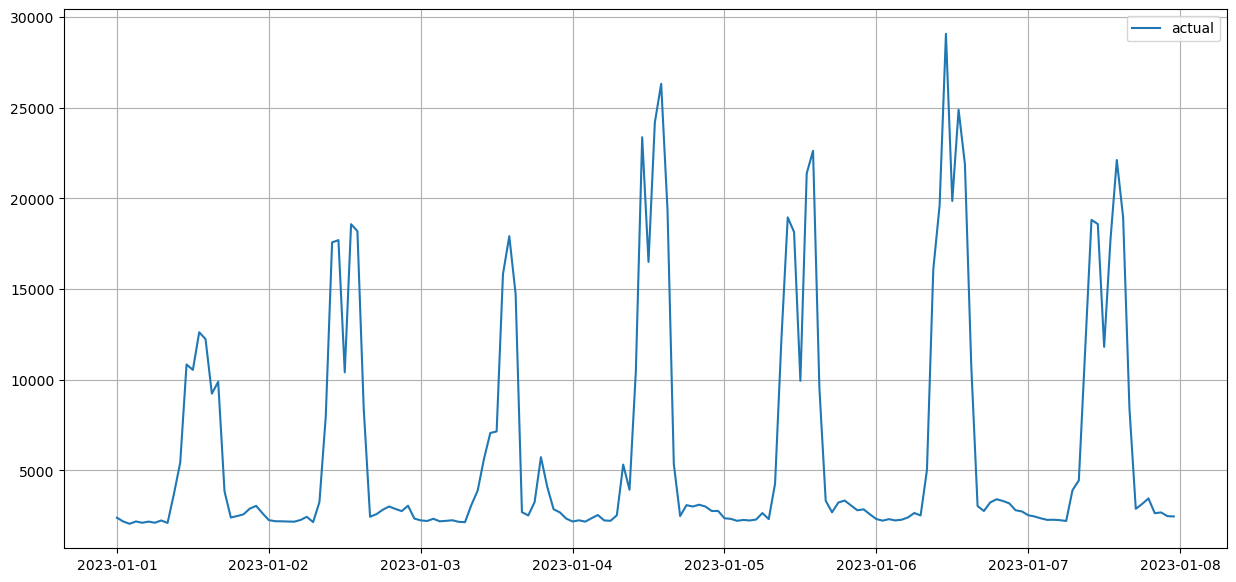

In [14]:
plt.figure(figsize=(15, 7))
# plt.plot(forecast, color="r", label="model")
# plt.axvspan(df.index[-FORECAST_HORIZON], df.index[-1], alpha=0.5, color="lightgrey")
plt.plot(segment, label="actual")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
df_train.to_csv("train.csv")

In [16]:
timestamp_test = pd.Timestamp(year=2023, month=2, day=10, tz=TIMEZONE)

In [20]:
def collect_test_data(test_timeseries: pd.DataFrame, history_length, forecast_length):
    timestamps = test_timeseries.index
    timestamps_realised = []
    histories = []
    forecast_actuals = []
    for timestamp in tqdm(timestamps):
        history = get_history(test_timeseries, timestamp, history_length)
        forecast_actual = get_actual_forecast(test_timeseries, timestamp, forecast_length)
        if history is None or forecast_actual is None:
            continue
        histories.append(history[VALUE_COLUMN].values)
        forecast_actuals.append(forecast_actual[VALUE_COLUMN].values)
        timestamps_realised.append(timestamp)
    assessment_result_dict = {
            "splitting_timestamp": timestamps_realised, 
            "history": histories,
            "forecast_actual": forecast_actuals
        }
    assessment_result_df = pd.DataFrame(assessment_result_dict)
    return assessment_result_df

In [21]:
test_data = collect_test_data(df_test, HISTORY_LENGTH, FORECAST_LENGTH)

100%|██████████| 6608/6608 [00:02<00:00, 2967.05it/s]


In [22]:
test_data.head()

,splitting_timestamp,history,forecast_actual
0,2023-01-08 00:00:00+07:00,"[2393.901, 2186.789, 2061.547, 2189.843, 2118....","[2262.046, 2246.15, 2137.219, 2204.374, 2149.2..."
1,2023-01-08 01:00:00+07:00,"[2186.789, 2061.547, 2189.843, 2118.177, 2181....","[2246.15, 2137.219, 2204.374, 2149.259, 2069.2..."
2,2023-01-08 02:00:00+07:00,"[2061.547, 2189.843, 2118.177, 2181.094, 2119....","[2137.219, 2204.374, 2149.259, 2069.298, 2143...."
3,2023-01-08 03:00:00+07:00,"[2189.843, 2118.177, 2181.094, 2119.278, 2244....","[2204.374, 2149.259, 2069.298, 2143.262, 2673...."
4,2023-01-08 04:00:00+07:00,"[2118.177, 2181.094, 2119.278, 2244.315, 2107....","[2149.259, 2069.298, 2143.262, 2673.702, 3488...."


In [48]:
test_data_shuffled = test_data.sample(frac=1, random_state=1).reset_index().drop(columns=["index"])

In [49]:
test_data_shuffled.head()

,splitting_timestamp,history,forecast_actual
0,2023-02-20 14:00:00+07:00,"[23792.326, 19787.305, 13165.008, 6443.164, 34...","[24882.531, 20363.996, 8705.372, 3945.662, 408..."
1,2023-05-05 02:00:00+07:00,"[2315.51, 2556.638, 2610.787, 2331.406, 2847.6...","[2469.457, 2429.121, 2411.644, 2565.482, 2493...."
2,2023-06-06 07:00:00+07:00,"[2092.205, 6270.864, 19247.117, 18555.769, 184...","[2608.225, 5598.622, 12915.379, 14472.625, 149..."
3,2023-05-25 05:00:00+07:00,"[2488.029, 2832.887, 2490.58, 5515.84, 14417.8...","[2214.323, 2631.932, 2524.225, 4975.401, 15936..."
4,2023-04-07 06:00:00+07:00,"[2304.194, 2784.768, 5625.376, 11209.057, 1751...","[2054.258, 2027.884, 4628.518, 6541.038, 11490..."


In [51]:
test_data_shuffled.drop(columns=["splitting_timestamp"]).to_csv("test.csv")

# Assessment

In [52]:
model_SARIMAX = Model(value_column=VALUE_COLUMN, season_length=24, forecast_length=FORECAST_LENGTH)

In [53]:
with open(MODEL_PATH, "rb") as model_file:
    model_SARIMAX.model_SARIMAX_fited = pickle.load(model_file)

In [54]:
# model_SARIMAX.set_parameters(p=4, d=1, q=4, P=0, D=1, Q=1) # TODO optimise hyper parameters

In [55]:
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     model_SARIMAX.fit(df_train[:-5000])

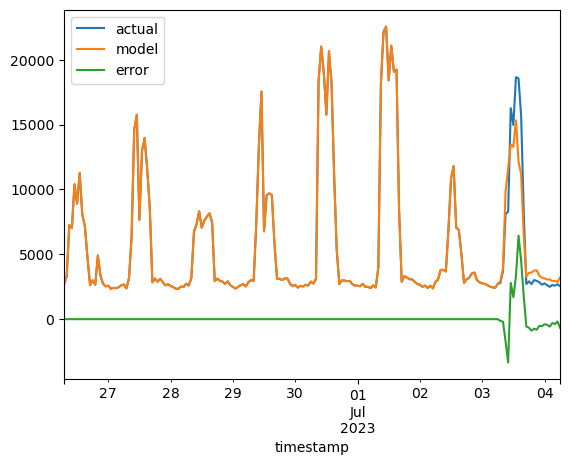

In [56]:
timestamp_validation = pd.Timestamp(year=2023, month=7, day=3, hour=7, tz=TIMEZONE)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    collect_simulation_on_timestamp_results(simulate_on_timestamp(model_SARIMAX, 
                                       df_test, timestamp_validation, HISTORY_LENGTH, FORECAST_LENGTH)).plot()

In [63]:
def simulate_on_test_data(model, test_data):
    assessment_result_df = copy.copy(test_data)
    forecasts = []
    ME = []
    MAE = []
    MAPE = []
    SMAPE = []
    RMSE = []
    STD = []
    R2 = []
    corr = []
    for i in tqdm(range(len(test_data))):
        row = test_data.iloc[i]
        history = row["history"]
        actual = row["forecast_actual"]
        forecast = model.forecast(history)
        forecasts.append(forecast)
        error = actual - forecast
        ME.append(np.mean(error))
        MAE.append(np.mean(np.absolute(error)))
        MAPE.append(np.mean(np.abs((actual - forecast) / actual)))
        SMAPE.append(1/len(actual) * np.sum(2 * np.abs(actual - forecast) / (np.abs(actual) + np.abs(forecast))))
        RMSE.append(np.sqrt(np.dot(error, error) / len(error)))
        STD.append(np.std(error))
        R2.append(r2_score(actual, forecast))
        corr.append(np.corrcoef(forecast, actual)[0,1])
    assessment_result_df["forecast"] = forecasts
    assessment_result_df["ME"] = ME
    assessment_result_df["MAE"] = MAE
    assessment_result_df["MAPE"] = MAPE
    assessment_result_df["SMAPE"] = SMAPE
    assessment_result_df["RMSE"] = RMSE
    assessment_result_df["STD"] = STD
    assessment_result_df["R2"] = R2
    assessment_result_df["corr"] = corr
    return assessment_result_df

In [64]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    assessment_result_df = simulate_on_test_data(model_SARIMAX, test_data)

100%|██████████| 4398/4398 [05:09<00:00, 14.21it/s]


In [67]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    assessment_result_df_shuffled = simulate_on_test_data(model_SARIMAX, test_data_shuffled)

100%|██████████| 4398/4398 [05:08<00:00, 14.24it/s]


In [65]:
assessment_result_df[["ME", "MAE", "MAPE", "SMAPE", "RMSE", "STD", "R2", "corr"]]

,ME,MAE,MAPE,SMAPE,RMSE,STD,R2,corr
0,-3786.667681,3786.667681,0.733881,0.491731,5771.080490,4355.056590,-2.004383,0.875658
1,-3739.089873,3739.089873,0.715008,0.478693,5751.608969,4370.379005,-1.987408,0.875287
2,-3723.842443,3723.842443,0.709178,0.475587,5739.108217,4366.962398,-1.983421,0.874892
3,-3673.032802,3673.032802,0.689312,0.461277,5715.074806,4378.459784,-1.971826,0.874242
4,-3693.425854,3693.425854,0.699694,0.470423,5710.298912,4355.010807,-1.969659,0.874205
...,...,...,...,...,...,...,...,...
4393,-1014.889254,1464.830833,0.401321,0.286577,2344.165773,2113.081393,-0.593492,0.668449
4394,-1254.355091,1519.073480,0.417078,0.289637,2445.988137,2099.869346,-0.723000,0.719685
4395,-1443.645857,1683.468821,0.463794,0.320245,2584.516048,2143.737354,-1.765129,0.690753
4396,-1459.623688,1688.378220,0.471500,0.328326,2570.273777,2115.610073,-3.545605,0.637821


In [66]:
assessment_result_df[["ME", "MAE", "MAPE", "SMAPE", "RMSE", "STD", "R2", "corr"]].mean()

ME       -296.637238
MAE      1924.250306
MAPE        0.334807
SMAPE       0.279886
RMSE     3036.369655
STD      2614.422802
R2         -2.413012
corr        0.880790
dtype: float64

In [68]:
assessment_result_df_shuffled[["ME", "MAE", "MAPE", "SMAPE", "RMSE", "STD", "R2", "corr"]].mean()

ME       -296.637238
MAE      1924.250306
MAPE        0.334807
SMAPE       0.279886
RMSE     3036.369655
STD      2614.422802
R2         -2.413012
corr        0.880790
dtype: float64

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    assessment_result_df = simulate_on_timeseries(model_SARIMAX, df_test, HISTORY_LENGTH, FORECAST_LENGTH)

100%|██████████| 6608/6608 [05:05<00:00, 21.61it/s] 


In [24]:
assessment_result_df

,timestamp,RMSE,R2,R2_2,MAE,MAPE,SMAPE,corr,errors_0,actuals_0,...,forecasts_20,errors_21,actuals_21,forecasts_21,errors_22,actuals_22,forecasts_22,errors_23,actuals_23,forecasts_23
0,2023-01-08 00:00:00+07:00,3.330537e+07,-2.004383,-2.004383,3786.667681,0.733881,0.491731,0.875658,-548.826292,2262.046,...,3993.473717,-838.247772,3012.921,3851.168772,-1040.546822,2656.537,3697.083822,-1052.649667,2507.782,3560.431667
1,2023-01-08 01:00:00+07:00,3.308101e+07,-1.987408,-1.987408,3739.089873,0.715008,0.478693,0.875287,-279.318894,2246.150,...,3832.516548,-1022.591519,2656.537,3679.128519,-1035.625417,2507.782,3543.407417,-1037.940333,2333.124,3371.064333
2,2023-01-08 02:00:00+07:00,3.293736e+07,-1.983421,-1.983421,3723.842443,0.709178,0.475587,0.874892,-490.021637,2137.219,...,3665.446778,-1020.762987,2507.782,3528.544987,-1024.676321,2333.124,3357.800321,-824.043024,2445.977,3270.020024
3,2023-01-08 03:00:00+07:00,3.266208e+07,-1.971826,-1.971826,3673.032802,0.689312,0.461277,0.874242,-86.469096,2204.374,...,3508.177207,-1005.324222,2333.124,3338.448222,-804.929421,2445.977,3250.906421,-798.618186,2423.363,3221.981186
4,2023-01-08 04:00:00+07:00,3.260751e+07,-1.969659,-1.969659,3693.425854,0.699694,0.470423,0.874205,-505.087366,2149.259,...,3331.538258,-794.913530,2445.977,3240.890530,-791.555800,2423.363,3214.918800,-912.848842,2262.633,3175.481842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,2023-10-09 08:00:00+07:00,5.495113e+06,-0.593492,-0.593492,1464.830833,0.401321,0.286577,0.668449,1288.067912,4264.804,...,2936.192398,694.841123,3636.084,2941.242877,-192.157118,2627.316,2819.473118,-91.922332,2575.298,2667.220332
4394,2023-10-09 09:00:00+07:00,5.982858e+06,-0.723000,-0.723000,1519.073480,0.417078,0.289637,0.719685,-437.137325,8729.888,...,2977.009459,-204.166740,2627.316,2831.482740,-123.665549,2575.298,2698.963549,-845.693916,2889.065,3734.758916
4395,2023-10-09 10:00:00+07:00,6.679723e+06,-1.765129,-1.765129,1683.468821,0.463794,0.320245,0.690753,-1558.401486,8591.092,...,2912.455997,-179.877882,2575.298,2755.175882,-923.976111,2889.065,3813.041111,-4216.685317,4225.503,8442.188317
4396,2023-10-09 11:00:00+07:00,6.606307e+06,-3.545605,-3.545605,1688.378220,0.471500,0.328326,0.637821,-1385.470754,7923.982,...,2824.782049,-976.223267,2889.065,3865.288267,-4288.105204,4225.503,8513.608204,-3966.237067,5184.316,9150.553067


In [25]:
metrics_SARIMAX = collect_metrics(assessment_result_df, FORECAST_LENGTH)

In [26]:
metrics_SARIMAX

,ME,MAE,MAPE,SMAPE,RMSE,STD,R2,corr
0,-137.574360,1235.509400,0.208440,0.192218,2203.679366,2199.380832,0.858384,0.927920
1,-200.763247,1701.891468,0.290780,0.254853,2987.605349,2980.852201,0.738981,0.864803
2,-257.693143,1862.359883,0.323110,0.278960,3238.948854,3228.681453,0.692437,0.840288
3,-270.315221,1910.352659,0.333126,0.285198,3326.694663,3315.694054,0.675572,0.831224
4,-301.234398,1941.765504,0.340657,0.287877,3380.845516,3367.398735,0.664323,0.825546
5,-307.528951,1963.617290,0.344404,0.287385,3430.630250,3416.818675,0.654658,0.820256
6,-327.489769,1978.083505,0.347046,0.285621,3465.322603,3449.813211,0.648529,0.816956
7,-324.529855,1978.981917,0.346103,0.284716,3482.876316,3467.723722,0.644918,0.815140
8,-337.175471,1983.702003,0.347933,0.285569,3489.804269,3473.477586,0.643854,0.814811
9,-329.914515,1987.462243,0.347904,0.286177,3501.142843,3485.564175,0.642218,0.814104


# Save

In [22]:
# model_SARIMAX.model_SARIMAX_fited.save("sarimax_168_24.pkl")